# Take-home Exam

Kivanc Dundar<br />
2015703045

### Setup & reading example data

Below are the codes I use to setup packages and read example data:

In [8]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt

import pandas as pd
import pandas.io.data as web

import numpy as np
import datetime

import sys

start = datetime.datetime(2012,1,1)
end = datetime.datetime(2016,7,1)

msft = web.DataReader("MSFT", "yahoo", start, end)
aapl = web.DataReader("AAPL", "yahoo", start, end)
amzn = web.DataReader("AMZN", "yahoo", start, end)

### Modified Implementation

Below is my modified implementation that answers Tasks 1 to 3.

I have defined a number of customers:
- Customer: able to buy and sell stock
- TrustedCustomer: able to shortsell
- SmartCustomer: tracks last 5 open/close prices and # of days, uses the information to decide when to buy stock (The strategy is to use the 10-day moving average price and buy when today's 'Open' < 10-day average 'Close' and vice versa)
- PairCustomer: similar to SmartCustomer but invests in a portfolio of 2 stocks

and a number of backtesters:
- BacktesterMod: Plots wealth and allocation, and allows cash to earn interest
- TrustedBacktester: Closes short positions at the end of each day
- SmartBacktester: Feeds open and close prices and # of period to SmartCustomer
- PairBacktester: Similar to SmartBacktester but is able to deal with 2 stocks at the same time


#### Task 1
Modify the program to create plots of the total wealth over time, along with the value of the stocks and cash at each time point.

#### Task 2
Add the following type of orders that a customer can issue

- AddCapital
- WithdrawCapital

The backtester should always keep track of the position of the trader and make appropriate checks, such as only allowing buying stocks allowed by the current capital.

#### Task 3
Add an interest_rate such that at the beginning of each trading day, the cash earns a fixed interest. Also, include transaction costs (a fixed percentage of the trade) to be deduced from each transaction.

### My response for Tasks 1 to 3:
(Taks 4, 5, and 6 are answered in separate code chunks)

___________________________________________________________
Wealth


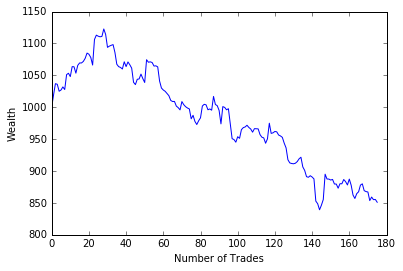

___________________________________________________________
Value of Cash


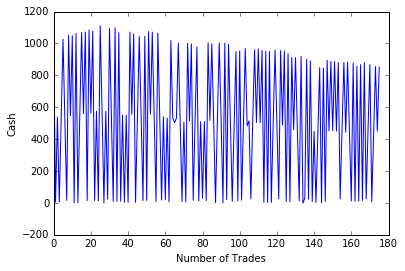

___________________________________________________________
Value of Stocks


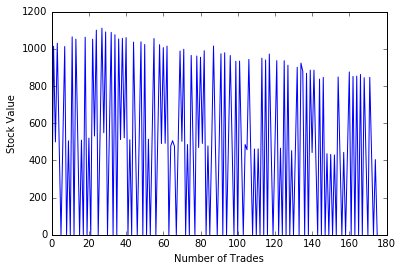

In [217]:
class Customer:
    def __init__(self, cash=10000):
        self.Position = {'Cash': cash, 'Stocks': 0.0} 

    def DecideTargetPosition(self):
        ## Randomly decide a portfolio output percentage of capital to put into stocks
        return np.random.choice([0.0, 0.5, 1.0])        
        
    def Capital(self, price):
        return self.Position['Cash'] + self.Position['Stocks']*price
        
    def PlaceOrder(self, price):
        p = self.DecideTargetPosition()
        capital = self.Capital(price)
        
        numLots = np.floor(capital*p/price)
        
        TargetPosition = {'Cash': capital-numLots*price, 'Stocks': numLots}
        
        if TargetPosition['Stocks']>self.Position['Stocks']:
            # Buy 
            return ('Buy', TargetPosition['Stocks']-self.Position['Stocks'])
        elif TargetPosition['Stocks']<self.Position['Stocks']:
            # Sell
            return ('Sell', -TargetPosition['Stocks']+self.Position['Stocks'])
        else:
            # Do nothing
            None
            
    def GetPosition(self):
        return self.Position
    
    def UpdatePosition(self, deltaCash, deltaStock):
        self.Position['Cash'] += deltaCash
        self.Position['Stocks'] += deltaStock
        return
    
    def AddCapital(self, cash_to_add):
        self.Position['Cash'] += cash_to_add
        return       
    
    def WithdrawCapital(self, cash_to_withdraw):
        if cash_to_withdraw > (self.Position['Cash'] + self.Position['Stocks']*price):
            return ('Insufficient capital')
        else:        
            if self.Position['Cash'] >= cash_to_withdraw:

                self.Position['Cash'] -= cash_to_withdraw
                return ('Withdrawn', cash_to_withdraw)

            elif self.Position['Cash'] < cash_to_withdraw:

                deficit = cash_to_withdraw - self.Position['Cash']
                
                withdrawn_cash = self.Position['Cash']
                self.Position['Cash'] = 0

                stock_to_sell = np.ceil(float(deficit)/price)

                self.Position['Stocks'] -= stock_to_sell
                cash_from_stock = stock_to_sell*price

                withdrawn_capital = withdrawn_cash + cash_from_stock
                return ('Withdrawn', withdrawn_capital)
    

def BackTesterMod(series, customer, interest_rate, commision):
    
    Wealth = [customer.GetPosition()['Cash']]
    CashValue = [customer.GetPosition()['Cash']]
    StockValue = [0]
    
    openPrice = series['Open']
    closePrice = series['Close']
    
    # Daily interest rate calculated assuming 252 working days per year
    dailyInterest = interest_rate*1./252
        
    for k in openPrice.keys():
        price = openPrice[k]
        order = customer.PlaceOrder(price) 
        
        if order is None:
            continue
            
        # I have disabled printing each order and capital as these take too much space
        # print order
        
        #Buy order has been modified to disallow buying stock above total capital
        if order[0]=='Buy':
            transactionCost = price*commision*abs(order[1])
            if customer.GetPosition()['Cash'] < price*order[1]:
                sys.exit("Error: Insufficient capital.")
            else:
                deltaCash = -price*order[1] - transactionCost
                deltaStock = order[1]
                customer.UpdatePosition(deltaCash, deltaStock)
            
        elif order[0]=='Sell':
            
            transactionCost = price*commision*abs(order[1])
            
            deltaCash = price*order[1] - transactionCost
            deltaStock = -order[1]            
            customer.UpdatePosition(deltaCash, deltaStock)
        
        else:
            None
                     
        price = closePrice[k]
        # I have disabled printing each order and capital as these take too much space
        # print k, customer.Capital(price)
        
        cash_interest = customer.GetPosition()['Cash']*dailyInterest
        customer.UpdatePosition(cash_interest, 0)
        
        Wealth.append(customer.Capital(price))
        
        CashValue.append(customer.GetPosition()['Cash'])
        StockValue.append(customer.GetPosition()['Stocks']*price)
        
        
      
    ## Plotting the results:
    
    print "___________________________________________________________"    
    print "Wealth"
    
    plt.plot(Wealth)
    plt.ylabel('Wealth')
    plt.xlabel('Number of Trades')
    plt.show()
    
    print "___________________________________________________________"    
    print "Value of Cash"
    
    plt.plot(CashValue)
    plt.ylabel('Cash')
    plt.xlabel('Number of Trades')
    plt.show()
    
    print "___________________________________________________________"    
    print "Value of Stocks"
    
    plt.plot(StockValue)
    plt.ylabel('Stock Value')
    plt.xlabel('Number of Trades')
    plt.show()
    
Cash = 1000
cust = Customer(cash=Cash)

BackTesterMod(msft['2012'], cust, 0.05, 0.002)

### Task 4
Modify the system such that it allows for open selling, that is selling without actually owning any stock. At the end of the trading day, any open positions should be cleared by the closing price.

___________________________________________________________
Wealth


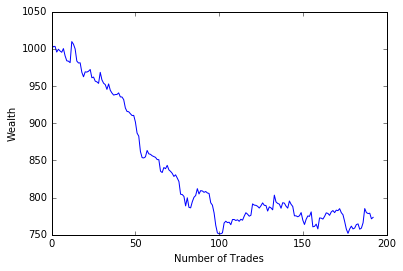

___________________________________________________________
Value of Cash


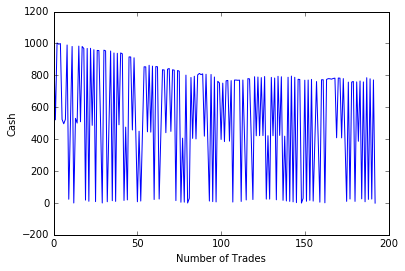

___________________________________________________________
Value of Stocks


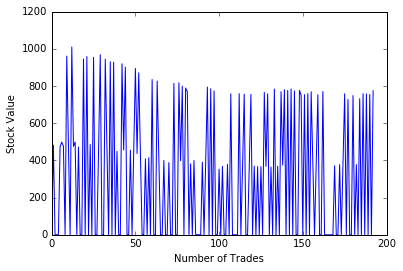

In [216]:
## TrustedCustomer is able to shortsell stock
class TrustedCustomer:
    def __init__(self, cash=10000):
        self.Position = {'Cash': cash, 'Stocks': 0.0} 
    
    def DecideTargetPosition(self):
        ## Randomly decide a portfolio output percentage of capital to put into stocks
        ## In this version DecideTargetPosition is able to short stock worth 50% of capital resulting in 150% cash
        return np.random.choice([-0.5, 0.0, 0.5, 1.0])       

    def Capital(self, price):
        return self.Position['Cash'] + self.Position['Stocks']*price
        
    def PlaceOrder(self, price):
        p = self.DecideTargetPosition()
        capital = self.Capital(price)
        
        numLots = np.floor(capital*p/price)
        
        TargetPosition = {'Cash': capital-numLots*price, 'Stocks': numLots}
        
        if TargetPosition['Stocks']>self.Position['Stocks']:
            # Buy 
            return ('Buy', TargetPosition['Stocks']-self.Position['Stocks'])
        elif TargetPosition['Stocks']<self.Position['Stocks']:
            # Sell
            return ('Sell', -TargetPosition['Stocks']+self.Position['Stocks'])
        else:
            # Do nothing
            None
            
    def GetPosition(self):
        return self.Position
    
    def UpdatePosition(self, deltaCash, deltaStock):
        self.Position['Cash'] += deltaCash
        self.Position['Stocks'] += deltaStock
        return
    
    def AddCapital(self, cash_to_add):
        self.Position['Cash'] += cash_to_add
        return       
    
    def WithdrawCapital(self, cash_to_withdraw):
        if cash_to_withdraw > (self.Position['Cash'] + self.Position['Stocks']*price):
            return ('Insufficient capital')
        else:        
            if self.Position['Cash'] >= cash_to_withdraw:

                self.Position['Cash'] -= cash_to_withdraw
                return ('Withdrawn', cash_to_withdraw)

            elif self.Position['Cash'] < cash_to_withdraw:

                deficit = cash_to_withdraw - self.Position['Cash']
                
                withdrawn_cash = self.Position['Cash']
                self.Position['Cash'] = 0

                stock_to_sell = np.ceil(float(deficit)/price)

                self.Position['Stocks'] -= stock_to_sell
                cash_from_stock = stock_to_sell*price

                withdrawn_capital = withdrawn_cash + cash_from_stock
                return ('Withdrawn', withdrawn_capital)
    

## Backtester is modified to close short positions at the end of each day with closing price
def TrustedBackTester(series, customer, interest_rate, commision):
    
    Wealth = [customer.GetPosition()['Cash']]
    CashValue = [customer.GetPosition()['Cash']]
    StockValue = [0]
    
    openPrice = series['Open']
    closePrice = series['Close']
    
    # Daily interest rate calculated assuming 252 working days per year
    dailyInterest = interest_rate*1./252
        
    for k in openPrice.keys():
        price = openPrice[k]
        order = customer.PlaceOrder(price) 
        
        if order is None:
            continue
        
        # I have disabled printing each order and capital as these take too much space
        # print order
        
        # Buy order has been modified to disallow buying stock above total capital - transaction cost is ignored
        # but that can presumably borrowed from the broker (allocating 100% to stock is possible even if there is no
        # money left for transaction cost)
        if order[0]=='Buy':
            transactionCost = price*commision*abs(order[1])
            if customer.GetPosition()['Cash'] < (price*order[1]):
                sys.exit("Error: Insufficient capital.")
            else:
                deltaCash = -price*order[1] - transactionCost
                deltaStock = order[1]
                customer.UpdatePosition(deltaCash, deltaStock)
            
        elif order[0]=='Sell':
            
            transactionCost = price*commision*abs(order[1])
            
            deltaCash = price*order[1] - transactionCost
            deltaStock = -order[1]            
            customer.UpdatePosition(deltaCash, deltaStock)
        
        else:
            None
                     
        price = closePrice[k]
        
        # Following modification closes short positions
        if customer.Position['Stocks'] < 0:
            
            ShortPosition = -customer.Position['Stocks']
            transactionCost = price*commision*abs(ShortPosition)
            deltaCash = -price*ShortPosition - transactionCost
            deltaStock = ShortPosition
            customer.UpdatePosition(deltaCash, deltaStock)
        else:
            None        
        
        # I have disabled printing each order and capital as these take too much space
        # print k, customer.Capital(price)
        
        
        cash_interest = customer.GetPosition()['Cash']*dailyInterest
        customer.UpdatePosition(cash_interest, 0)
        
        Wealth.append(customer.Capital(price))
        
        CashValue.append(customer.GetPosition()['Cash'])
        StockValue.append(customer.GetPosition()['Stocks']*price)
        
        
      
    ## Plotting the results:
    
    print "___________________________________________________________"    
    print "Wealth"
    
    plt.plot(Wealth)
    plt.ylabel('Wealth')
    plt.xlabel('Number of Trades')
    plt.show()
    
    print "___________________________________________________________"    
    print "Value of Cash"
    
    plt.plot(CashValue)
    plt.ylabel('Cash')
    plt.xlabel('Number of Trades')
    plt.show()
    
    print "___________________________________________________________"    
    print "Value of Stocks"
    
    plt.plot(StockValue)
    plt.ylabel('Stock Value')
    plt.xlabel('Number of Trades')
    plt.show()
    
Cash = 1000
cust2 =  TrustedCustomer(cash=Cash)

TrustedBackTester(msft['2012'], cust2, 0.05, 0.002)

### Task 5
Think and implement a trading policy of your imagination, such as estimating the trend in the last few days, and coming up with a smarter decision than random. Compare your policy with the random policy in terms of earnings or losses.

___________________________________________________________
Wealth


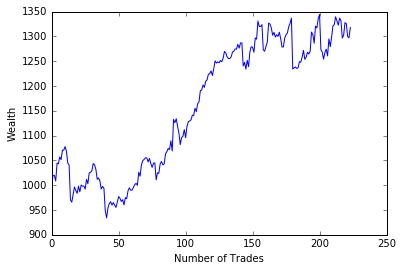

___________________________________________________________
Value of Cash


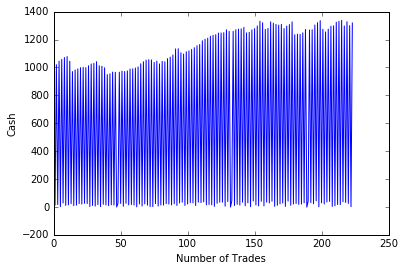

___________________________________________________________
Value of Stocks


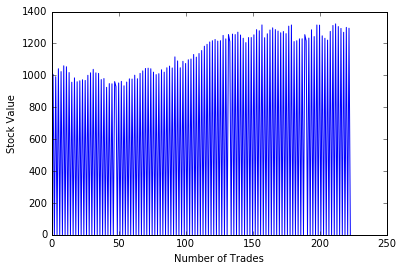

In [218]:
## SmartCustomer uses a smarter decision than random
class SmartCustomer:
    def __init__(self, cash=10000):
        self.Position = {'Cash': cash, 
                         'Stocks': 0.0, 
                         'Runs': 0,  
                         'Open_Prices': [0., 0., 0., 0., 0.,], 
                         'Close_Prices': [0] * 10} 

    def TrackRuns(self, num_runs):
        self.Position['Runs'] += num_runs

    # this function keeps the last 5 Open prices in memory (Not used in my strategy)
    def TrackOpen(self, price):
        self.Position['Open_Prices'][0] = self.Position['Open_Prices'][1]
        self.Position['Open_Prices'][1] = self.Position['Open_Prices'][2]
        self.Position['Open_Prices'][2] = self.Position['Open_Prices'][3]
        self.Position['Open_Prices'][3] = self.Position['Open_Prices'][4]
        self.Position['Open_Prices'][4] = price
    
    # this function keeps the last 10 Close prices in memory
    def TrackClose(self, price):
        # k is the # of days to calculate moving average
        days = 10
        for i in range (0,days-1):
            self.Position['Close_Prices'][i] = self.Position['Close_Prices'][i+1]
            
        self.Position['Close_Prices'][days-1] = price
        
    def DecideTargetPosition(self, price):
        ## Strategy: Keep cash for the first 10 days to observe average
        if self.Position['Runs'] < 11:
            return 0.
        # Compares today's 'Open' with a 10-day moving avearage of 'Close'
        # Buy when todays 'Open' chepaer than the average 'Close'
        elif self.Position['Runs'] >= 11:
            average_price = np.average(self.Position['Close_Prices'])
            if price < average_price:
                return 1.
            else:
                return 0.
            
        ## return np.random.choice([-0.5, 0.0, 0.5, 1.0])             
    def Capital(self, price):
        return self.Position['Cash'] + self.Position['Stocks']*price
        
    def PlaceOrder(self, price):
        p = self.DecideTargetPosition(price)
        capital = self.Capital(price)
        
        numLots = np.floor(capital*p/price)
        
        TargetPosition = {'Cash': capital-numLots*price, 'Stocks': numLots}
        
        if TargetPosition['Stocks']>self.Position['Stocks']:
            # Buy 
            return ('Buy', TargetPosition['Stocks']-self.Position['Stocks'])
        elif TargetPosition['Stocks']<self.Position['Stocks']:
            # Sell
            return ('Sell', -TargetPosition['Stocks']+self.Position['Stocks'])
        else:
            # Do nothing
            None
            
    def GetPosition(self):
        return self.Position
    
    def UpdatePosition(self, deltaCash, deltaStock):
        self.Position['Cash'] += deltaCash
        self.Position['Stocks'] += deltaStock
        return
    
    def AddCapital(self, cash_to_add):
        self.Position['Cash'] += cash_to_add
        return       
    
    def WithdrawCapital(self, cash_to_withdraw):
        if cash_to_withdraw > (self.Position['Cash'] + self.Position['Stocks']*price):
            return ('Insufficient capital')
        else:        
            if self.Position['Cash'] >= cash_to_withdraw:

                self.Position['Cash'] -= cash_to_withdraw
                return ('Withdrawn', cash_to_withdraw)

            elif self.Position['Cash'] < cash_to_withdraw:

                deficit = cash_to_withdraw - self.Position['Cash']
                
                withdrawn_cash = self.Position['Cash']
                self.Position['Cash'] = 0

                stock_to_sell = np.ceil(float(deficit)/price)

                self.Position['Stocks'] -= stock_to_sell
                cash_from_stock = stock_to_sell*price

                withdrawn_capital = withdrawn_cash + cash_from_stock
                return ('Withdrawn', withdrawn_capital)
    

# SmartBackTester lets the user know of the realized open/close prices and # of runs thus far
def SmartBackTester(series, customer, interest_rate, commision):
    Wealth = [customer.GetPosition()['Cash']]
    CashValue = [customer.GetPosition()['Cash']]
    StockValue = [0]
      
    openPrice = series['Open']
    closePrice = series['Close']
       
    # Daily interest rate calculated assuming 252 working days per year
    dailyInterest = interest_rate*1./252
       
    for k in openPrice.keys():
        ## Following lines (commented out) are useful for checking the code (backup) 
        ## print customer.Position['Close_Prices']
        ## print customer.Position['Runs']
        price = openPrice[k]
        customer.TrackOpen(price)
         
        order = customer.PlaceOrder(price)
        
        if order is None:
            price = closePrice[k]
            customer.TrackClose(price)
            customer.TrackRuns(1)
            continue
            
        # I have disabled printing each order and capital as these take too much space
        # print order
        
        #Buy order has been modified to disallow buying stock above total capital
        if order[0]=='Buy':
            transactionCost = price*commision*abs(order[1])
            if customer.GetPosition()['Cash'] < price*order[1]:
                sys.exit("Error: Insufficient capital.")
            else:
                deltaCash = -price*order[1] - transactionCost
                deltaStock = order[1]
                customer.UpdatePosition(deltaCash, deltaStock)
            
        elif order[0]=='Sell':
            transactionCost = price*commision*abs(order[1])
            deltaCash = price*order[1] - transactionCost
            deltaStock = -order[1]            
            customer.UpdatePosition(deltaCash, deltaStock)
        
        else:
            None
                     
        price = closePrice[k]
        customer.TrackClose(price)
        customer.TrackRuns(1)
            
        # Following modification closes short positions
        if customer.Position['Stocks'] < 0:
            ShortPosition = -customer.Position['Stocks']
            transactionCost = price*commision*abs(ShortPosition)
            deltaCash = -price*ShortPosition - transactionCost
            deltaStock = ShortPosition
            customer.UpdatePosition(deltaCash, deltaStock)
        else:
            None        
        
        # I have disabled printing each order and capital as these take too much space
        # print k, customer.Capital(price)
        
        
        cash_interest = customer.GetPosition()['Cash']*dailyInterest
        customer.UpdatePosition(cash_interest, 0)
        
        Wealth.append(customer.Capital(price))
        CashValue.append(customer.GetPosition()['Cash'])
        StockValue.append(customer.GetPosition()['Stocks']*price)
        
      
    ## Plotting the results:
    
    print "___________________________________________________________"    
    print "Wealth"
    
    plt.plot(Wealth)
    plt.ylabel('Wealth')
    plt.xlabel('Number of Trades')
    plt.show()
    
    print "___________________________________________________________"    
    print "Value of Cash"
    
    plt.plot(CashValue)
    plt.ylabel('Cash')
    plt.xlabel('Number of Trades')
    plt.show()
    
    print "___________________________________________________________"    
    print "Value of Stocks"
    
    plt.plot(StockValue)
    plt.ylabel('Stock Value')
    plt.xlabel('Number of Trades')
    plt.show()
    
Cash = 1000
cust3 =  SmartCustomer(cash=Cash)

SmartBackTester(msft, cust3, 0.05, 0.002)

### Task 5 (b) Comparison of results

While I haven't performed an exhaustive Monte Carlo simulation for the returns of random allocation of capital, based on my few trials it seems like choosing randomly generally returns negative earnings.

A relatively simple moving average strategy beats random allocation in the long run.

---------- Example returns from random allocation ----------
___________________________________________________________
Wealth


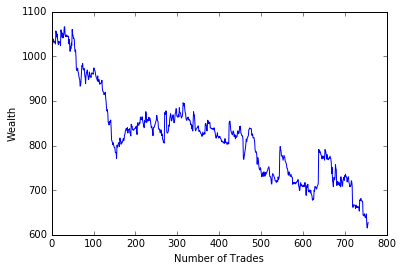

___________________________________________________________
Value of Cash


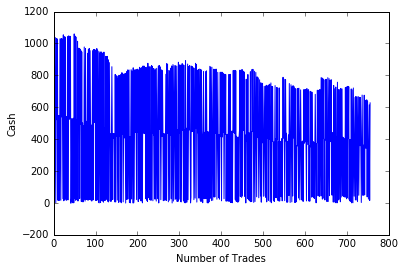

___________________________________________________________
Value of Stocks


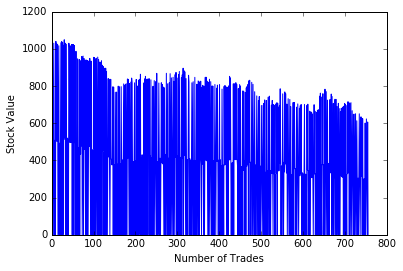

----------- Returns from moving average strategy -----------
___________________________________________________________
Wealth


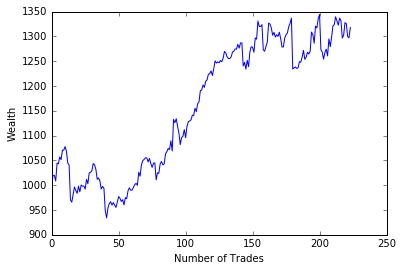

___________________________________________________________
Value of Cash


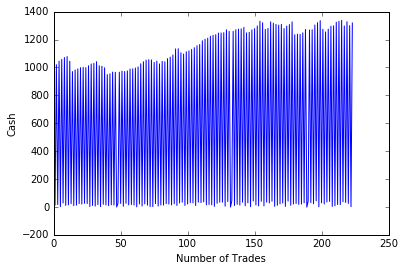

___________________________________________________________
Value of Stocks


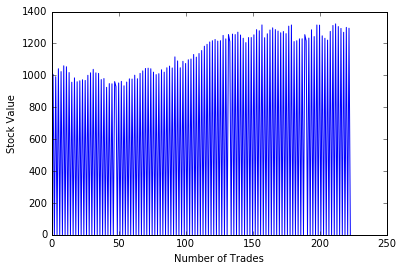

In [219]:
Cash = 1000
CustA =  Customer(cash=Cash)
CustB =  SmartCustomer(cash=Cash)
print '---------- Example returns from random allocation ----------'
BackTesterMod(msft, CustA, 0.05, 0.002)
print '----------- Returns from moving average strategy -----------'
SmartBackTester(msft, CustB, 0.05, 0.002)

### Task 6
Modify the program such that you allow for pairs trading. Modify the backtester such that you input a pair of stocks. Now the generated investment decisions must be portfolio. Repeat task 5 for the pairs case.

___________________________________________________________
Wealth


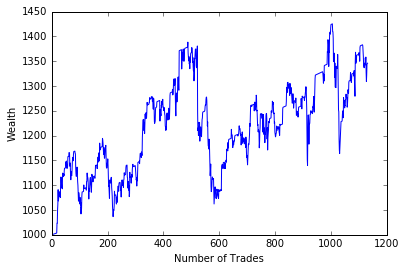

___________________________________________________________
Value of Cash


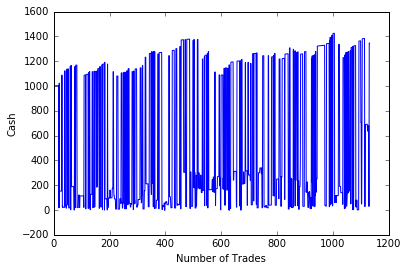

___________________________________________________________
Value of Stocks


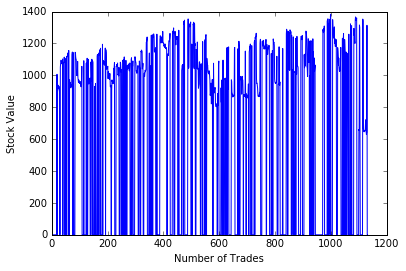

In [6]:
## This smart customer is trading two stocks 'Stocks' is an array with [weight_of_stock_A, weight_of_stock_B]
class PairCustomer:
    def __init__(self, cash=10000):
        self.Position = {'Cash': cash, 
                         'Stocks': [0., 0.],
                         'Runs': 0,  
                         'Close_Prices_A': [0.] * 10, 
                         'Close_Prices_B': [0.] * 10} 

    def TrackRuns(self, num_runs):
        self.Position['Runs'] += num_runs
   
    # this function keeps the last 10 Close prices in memory
    def TrackCloseA(self, price_A):
        # k is the # of days to calculate moving average
        days = 10
        for i in range (0,days-1):
            self.Position['Close_Prices_A'][i] = self.Position['Close_Prices_A'][i+1]
        self.Position['Close_Prices_A'][days-1] = price_A
    
    def TrackCloseB(self, price_B):
        days = 10
        for i in range (0,days-1):
            self.Position['Close_Prices_B'][i] = self.Position['Close_Prices_B'][i+1]
        self.Position['Close_Prices_B'][days-1] = price_B
        
    def DecideTargetPosition(self, price_A, price_B):       
        ## Strategy: Keep cash for the first 10 days to observe average
        if self.Position['Runs'] < 11:
            return [0.,0.]
        # Compares today's 'Open' with a 10-day moving avearage of 'Close'
        # Buy when todays 'Open' chepaer than the average 'Close'
        elif self.Position['Runs'] >= 11:
            average_price_A = np.average(self.Position['Close_Prices_A'])
            average_price_B = np.average(self.Position['Close_Prices_B'])
            if price_A < average_price_A and price_B < average_price_B:
                return [0.5, 0.5]
            elif price_A < average_price_A and price_B > average_price_B:
                return [1.,0.]
            elif price_A > average_price_A and price_B < average_price_B:
                return [0.,1.]
            elif price_A > average_price_A and price_B > average_price_B:
                return [0.,0.]
            else:
                return [0.,0.]
                        
    def Capital(self, price_A, price_B):
        return self.Position['Cash'] + self.Position['Stocks'][0]*price_A + self.Position['Stocks'][1]*price_B
        
    def PlaceOrder(self, price_A, price_B):
        p = self.DecideTargetPosition(price_A, price_B)
        capital = self.Capital(price_A, price_B)
        
        numLotsA = np.floor(capital*p[0]/price_A)
        numLotsB = np.floor(capital*p[1]/price_B)
                
        TargetPosition = {'Cash': capital-numLotsA*price_A-numLotsB*price_B, 'Stocks': [numLotsA, numLotsB]}

        # Note to self: Need to add a 3rd option (Buy, Sell, Hold)
        
        if TargetPosition['Stocks'][0]>self.Position['Stocks'][0] and TargetPosition['Stocks'][1]>self.Position['Stocks'][1]:          
            return (['Buy', 'Buy'], [TargetPosition['Stocks'][0]-self.Position['Stocks'][0],TargetPosition['Stocks'][1]-self.Position['Stocks'][1]])
        elif TargetPosition['Stocks'][0]>self.Position['Stocks'][0] and TargetPosition['Stocks'][1]<self.Position['Stocks'][1]:          
            return (['Buy', 'Sell'], [TargetPosition['Stocks'][0]-self.Position['Stocks'][0],-TargetPosition['Stocks'][1]+self.Position['Stocks'][1]])
        elif TargetPosition['Stocks'][0]>self.Position['Stocks'][0] and TargetPosition['Stocks'][1]==self.Position['Stocks'][1]:          
            return (['Buy', 'Hold'], [TargetPosition['Stocks'][0]-self.Position['Stocks'][0],0])
        
        elif TargetPosition['Stocks'][0]<self.Position['Stocks'][0] and TargetPosition['Stocks'][1]>self.Position['Stocks'][1]:          
            return (['Sell', 'Buy'], [-TargetPosition['Stocks'][0]+self.Position['Stocks'][0],TargetPosition['Stocks'][1]-self.Position['Stocks'][1]])
        elif TargetPosition['Stocks'][0]<self.Position['Stocks'][0] and TargetPosition['Stocks'][1]<self.Position['Stocks'][1]:          
            return (['Sell', 'Sell'], [-TargetPosition['Stocks'][0]+self.Position['Stocks'][0],-TargetPosition['Stocks'][1]+self.Position['Stocks'][1]])
        elif TargetPosition['Stocks'][0]<self.Position['Stocks'][0] and TargetPosition['Stocks'][1]==self.Position['Stocks'][1]:          
            return (['Sell', 'Hold'], [-TargetPosition['Stocks'][0]+self.Position['Stocks'][0],0])
        
        elif TargetPosition['Stocks'][0]==self.Position['Stocks'][0] and TargetPosition['Stocks'][1]>self.Position['Stocks'][1]:          
            return (['Hold', 'Buy'], [0,TargetPosition['Stocks'][1]-self.Position['Stocks'][1]])
        elif TargetPosition['Stocks'][0]==self.Position['Stocks'][0] and TargetPosition['Stocks'][1]<self.Position['Stocks'][1]:          
            return (['Hold', 'Sell'], [0,-TargetPosition['Stocks'][1]+self.Position['Stocks'][1]])
        elif TargetPosition['Stocks'][0]==self.Position['Stocks'][0] and TargetPosition['Stocks'][1]==self.Position['Stocks'][1]:          
            return (['Hold', 'Hold'], [0,0])
        else:
            None
            
    def GetPosition(self):
        return self.Position
    
    def UpdatePosition(self, deltaCash, deltaStockA, deltaStockB):
        self.Position['Cash'] += deltaCash
        self.Position['Stocks'][0] += deltaStockA
        self.Position['Stocks'][1] += deltaStockB
        return
    
# I have not created AddCapital and Withdraw capital functions for the pair exercise as they are not necessary

# PairBackTester works with 2 stocks
def PairBackTester(series_A, series_B, customer, interest_rate, commision):
    # Daily interest rate calculated assuming 252 working days per year
    dailyInterest = interest_rate*1./252
    
    Wealth = [customer.GetPosition()['Cash']]
    CashValue = [customer.GetPosition()['Cash']]
    StockValue = [0]
    StockValueA = [0]
    StockValueB = [0]
      
    openPriceA = series_A['Open']
    closePriceA = series_A['Close']
    
    openPriceB = series_B['Open']
    closePriceB = series_B['Close']
       

    for k in openPriceA.keys():
        price_A = openPriceA[k]
        price_B = openPriceB[k]
        order = customer.PlaceOrder(price_A, price_B)

        # Note to self: Need to add a 3rd option (Buy, Sell, Hold)

        if order==['Hold','Hold']:
            price_A = closePriceA[k]
            price_B = closePriceB[k]
            customer.TrackCloseA(price_A)
            customer.TrackCloseB(price_B)
            customer.TrackRuns(1)
            continue

        if order[0]==['Buy','Buy']:
            transactionCostA = price_A*commision*abs(order[1][0])
            transactionCostB = price_B*commision*abs(order[1][1])
            deltaCash = -transactionCostA-transactionCostB-price_A*order[1][0]-price_B*order[1][1]
            deltaStockA = order[1][0]
            deltaStockB = order[1][1]
            customer.UpdatePosition(deltaCash, deltaStockA, deltaStockB)
            
        elif order[0]==['Buy','Sell']:
            transactionCostA = price_A*commision*abs(order[1][0])
            transactionCostB = price_B*commision*abs(order[1][1])
            deltaCash = -transactionCostA-transactionCostB-price_A*order[1][0]+price_B*order[1][1]
            deltaStockA = order[1][0]
            deltaStockB = -order[1][1]
            customer.UpdatePosition(deltaCash, deltaStockA, deltaStockB)
            
        elif order[0]==['Buy','Hold']:
            transactionCostA = price_A*commision*abs(order[1][0])
            deltaCash = -transactionCostA-price_A*order[1][0]
            deltaStockA = order[1][0]
            deltaStockB = 0
            customer.UpdatePosition(deltaCash, deltaStockA, deltaStockB)
        
        elif order[0]==['Sell','Buy']:
            transactionCostA = price_A*commision*abs(order[1][0])
            transactionCostB = price_B*commision*abs(order[1][1])
            deltaCash = -transactionCostA-transactionCostB+price_A*order[1][0]-price_B*order[1][1]
            deltaStockA = -order[1][0]
            deltaStockB = order[1][1]
            customer.UpdatePosition(deltaCash, deltaStockA, deltaStockB)
        
        elif order[0]==['Sell','Sell']:
            transactionCostA = price_A*commision*abs(order[1][0])
            transactionCostB = price_B*commision*abs(order[1][1])
            deltaCash = -transactionCostA-transactionCostB+price_A*order[1][0]+price_B*order[1][1]
            deltaStockA = -order[1][0]
            deltaStockB = -order[1][1]   
            customer.UpdatePosition(deltaCash, deltaStockA, deltaStockB)
        
        elif order[0]==['Sell','Hold']:
            transactionCostA = price_A*commision*abs(order[1][0])
            deltaCash = -transactionCostA+price_A*order[1][0]
            deltaStockA = -order[1][0]
            deltaStockB = 0 
            customer.UpdatePosition(deltaCash, deltaStockA, deltaStockB)
        
        elif order[0]==['Hold','Buy']:
            transactionCostB = price_B*commision*abs(order[1][1])
            deltaCash = -transactionCostB-price_B*order[1][1]
            deltaStockA = 0
            deltaStockB = order[1][1]
            customer.UpdatePosition(deltaCash, deltaStockA, deltaStockB)
        
        elif order[0]==['Hold','Sell']:
            transactionCostB = price_B*commision*abs(order[1][1])
            deltaCash = -transactionCostB+price_B*order[1][1]
            deltaStockA = 0
            deltaStockB = -order[1][1]   
            customer.UpdatePosition(deltaCash, deltaStockA, deltaStockB)
        
        else:
            None
                     
        price_A = closePriceA[k]
        price_B = closePriceB[k]
        customer.TrackCloseA(price_A)
        customer.TrackCloseB(price_B)
        customer.TrackRuns(1)
        
        # I have not coded measures to close short positions since I don't have a shorting strategy 
    
        cash_interest = customer.GetPosition()['Cash']*dailyInterest
        customer.UpdatePosition(cash_interest, 0, 0)
    
        Wealth.append(customer.Capital(price_A, price_B))
        CashValue.append(customer.GetPosition()['Cash'])
        StockValue.append(customer.GetPosition()['Stocks'][0]*price_A+customer.GetPosition()['Stocks'][1]*price_B)
        
        
      
    print "___________________________________________________________"    
    print "Wealth"
    
    plt.plot(Wealth)
    plt.ylabel('Wealth')
    plt.xlabel('Number of Trades')
    plt.show()
    
    print "___________________________________________________________"    
    print "Value of Cash"
    
    plt.plot(CashValue)
    plt.ylabel('Cash')
    plt.xlabel('Number of Trades')
    plt.show()
    
    print "___________________________________________________________"    
    print "Value of Stocks"
    
    plt.plot(StockValue)
    plt.ylabel('Stock Value')
    plt.xlabel('Number of Trades')
    plt.show()
    
Cash = 1000
PairCust =  PairCustomer(cash=Cash)

PairBackTester(msft, amzn, PairCust, 0.05, 0.002)


The results show that while the strategy generates considerable returns, the volatility is quite high. From trade 500 to 600, almost all of the previous returns are lost, also around trade 900 and around trade 1100 there are short dips in wealth. An actual investor may not be able to bear "shocks" such as these.

### Appendix

Trials & errors for various tasks

Task 2 Illustration

In [188]:
class Customer:
    def __init__(self, cash=10000):
        self.Position = {'Cash': cash, 'Stocks': 10.0} 
        
    def WithdrawCapital(self, cash_to_withdraw):
        if cash_to_withdraw > (self.Position['Cash'] + self.Position['Stocks']*price):
            return ('Insufficient capital')
        else:        
            if self.Position['Cash'] >= cash_to_withdraw:

                self.Position['Cash'] -= cash_to_withdraw
                return ('Withdrawn', cash_to_withdraw)

            elif self.Position['Cash'] < cash_to_withdraw:

                deficit = cash_to_withdraw - self.Position['Cash']
                
                withdrawn_cash = self.Position['Cash']
                self.Position['Cash'] = 0

                stock_to_sell = np.ceil(float(deficit)/price)

                self.Position['Stocks'] -= stock_to_sell
                cash_from_stock = stock_to_sell*price

                withdrawn_capital = withdrawn_cash + cash_from_stock
                return ('Withdrawn', withdrawn_capital)

Cash = 10
price = 3

# Trial run with small withdrawal amound
cust = Customer(cash=Cash)
print cust.Position
print cust.WithdrawCapital(8)
print cust.Position

print '_________________________________'

# Trial run with stock sale (non-integer)
cust = Customer(cash=Cash)
print cust.Position
print cust.WithdrawCapital(11)
print cust.Position

print '_________________________________'

# Trial run with large amount
cust = Customer(cash=Cash)
print cust.Position
print cust.WithdrawCapital(42)
print cust.Position

{'Stocks': 10.0, 'Cash': 10}
('Withdrawn', 8)
{'Stocks': 10.0, 'Cash': 2}
_________________________________
{'Stocks': 10.0, 'Cash': 10}
('Withdrawn', 13.0)
{'Stocks': 9.0, 'Cash': 0}
_________________________________
{'Stocks': 10.0, 'Cash': 10}
Insufficient capital
{'Stocks': 10.0, 'Cash': 10}


### Price Tracker

In [286]:
class SmartCustomer:
    def __init__(self, cash=10000):
        self.Position = {'Cash': cash, 'Stocks': 0.0, 'Runs': 0,  'Open_Prices': [0., 0., 0., 0., 0.,], 'Close_Prices':[0., 0., 0., 0., 0.,]} 

    # this function keeps the last 5 Open prices in memory
    def TrackOpen(self, price):
        self.Position['Open_Prices'][0] = self.Position['Open_Prices'][1]
        self.Position['Open_Prices'][1] = self.Position['Open_Prices'][2]
        self.Position['Open_Prices'][2] = self.Position['Open_Prices'][3]
        self.Position['Open_Prices'][3] = self.Position['Open_Prices'][4]
        self.Position['Open_Prices'][4] = price
    
    # this function keeps the last 5 Close prices in memory
    def TrackClose(self, price):
        self.Position['Close_Prices'][0] = self.Position['Close_Prices'][1]
        self.Position['Close_Prices'][1] = self.Position['Close_Prices'][2]
        self.Position['Close_Prices'][2] = self.Position['Close_Prices'][3]
        self.Position['Close_Prices'][3] = self.Position['Close_Prices'][4]
        self.Position['Close_Prices'][4] = price
        
# Trial runs
Cash = 100
cust3 =  SmartCustomer(cash=Cash)    

print cust3.Position['Close_Prices']
cust3.TrackClose(20.)
print cust3.Position['Close_Prices']
cust3.TrackClose(21.)
print cust3.Position['Close_Prices']
cust3.TrackClose(22.)
print cust3.Position['Close_Prices']

#how to calculate average
print np.average(cust3.Position['Close_Prices'])


[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 20.0]
[0.0, 0.0, 0.0, 20.0, 21.0]
[0.0, 0.0, 20.0, 21.0, 22.0]
12.6


### Run tracker

In [61]:
class SmartCustomer2:
    def __init__(self, cash=10000):
        self.Position = {'Cash': cash, 
                         'Stocks': 0.0, 
                         'Runs': 0,  
                         'Open_Prices': [3., 4., 5., 6., 7.,], 
                         'Close_Prices':[3., 4., 5., 6., 7.,]} 

    def TrackRuns(self, num_runs):
        self.Position['Runs'] += num_runs
        
    def DecideTargetPosition(self, price):
        ## Strategy: Keep cash for the first 5 days to observe average
        if self.Position['Runs'] < 6:
            return 0.
        # Compares today's 'Open' with a 5-day avearage 'Close'
        # Buy when todays price chepaer than the average
        elif self.Position['Runs'] >= 6:
            average_price = np.average(self.Position['Close_Prices'])
            if price < average_price:
                return 1.
            if price >= average_price:
                return 0.
  
    def Capital(self, price):
        return self.Position['Cash'] + self.Position['Stocks']*price
    
    def PlaceOrder(self, price):
        p = self.DecideTargetPosition(price)
        capital = self.Capital(price)
        
        numLots = np.floor(capital*p/price)
        
        TargetPosition = {'Cash': capital-numLots*price, 'Stocks': numLots}
        
        if TargetPosition['Stocks']>self.Position['Stocks']:
            # Buy 
            return ('Buy', TargetPosition['Stocks']-self.Position['Stocks'])
        elif TargetPosition['Stocks']<self.Position['Stocks']:
            # Sell
            return ('Sell', -TargetPosition['Stocks']+self.Position['Stocks'])
        else:
            # Do nothing
            None
        
Cash = 100
cust4 =  SmartCustomer2(cash=Cash)    
print cust4.Position['Runs']
cust4.TrackRuns(1)
print cust4.Position['Runs']
cust4.TrackRuns(8)
print cust4.Position['Runs']

        
            
print cust4.DecideTargetPosition(1)

cust4.PlaceOrder(1)

0
1
9
1.0


('Buy', 100.0)

### Reference Implementation

Below is the unedited reference implementation of the functions:

In [4]:
class Customer:
    def __init__(self, cash=10000):
        self.Position = {'Cash': cash, 'Stocks': 0.0} 

    def DecideTargetPosition(self):
        ## Randomly decide a portfolio output percentage of capital to put into stocks
        return np.random.choice([0.0, 0.5, 1.0])        
        
    def Capital(self, price):
        return self.Position['Cash'] + self.Position['Stocks']*price
        
    def PlaceOrder(self, price):
        p = self.DecideTargetPosition()
        capital = self.Capital(price)
        
        numLots = np.floor(capital*p/price)
        
        TargetPosition = {'Cash': capital-numLots*price, 'Stocks': numLots}
        
        if TargetPosition['Stocks']>self.Position['Stocks']:
            # Buy 
            return ('Buy', TargetPosition['Stocks']-self.Position['Stocks'])
        elif TargetPosition['Stocks']<self.Position['Stocks']:
            # Sell
            return ('Sell', -TargetPosition['Stocks']+self.Position['Stocks'])
        else:
            # Do nothing
            None
            
    def GetPosition(self):
        return self.Position
    def UpdatePosition(self, deltaCash, deltaStock):
        self.Position['Cash'] += deltaCash
        self.Position['Stocks'] += deltaStock
        return

def BackTester(series, customer, interest_rate):
    
    openPrice = series['Open']
    closePrice = series['Close']
        
    for k in openPrice.keys():
        price = openPrice[k]
        order = customer.PlaceOrder(price) 
        
        if order is None:
            continue
            
        print order
        
        if order[0]=='Buy':
            deltaCash = -price*order[1]
            deltaStock = order[1]
            customer.UpdatePosition(deltaCash, deltaStock)
        elif order[0]=='Sell':
            deltaCash = price*order[1]
            deltaStock = -order[1]            
            customer.UpdatePosition(deltaCash, deltaStock)
        else:
            None
            
        price = closePrice[k]
        print k, customer.Capital(price)
    
Cash = 1000
cust = Customer(cash=Cash)

# I have commented out the code that creates the output
# BackTester(msft['2012-01'], cust, 0.05)